In [46]:
import numpy as np
import pandas as pd
import sklearn
import nltk
# from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
from sklearn import feature_extraction,model_selection
from sklearn.metrics import confusion_matrix
import glob
import os
import string
import tensorflow as tf
import keras as K
import zipfile
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
def load_csv(path):
  df=pd.read_csv(path).drop(['Sub-task B','ID'],axis=1)
  df=df[(df['Sub-task A']=="NAG")|(df['Sub-task A']=='OAG')|(df['Sub-task A']=='CAG')].dropna()
  df['Sub-task A'] = df['Sub-task A'].map({'NAG': 0, 'CAG': 1, 'OAG' : 2})
  return df

In [50]:
train_df=load_csv("/content/drive/My Drive/hin_dev.csv")
dev_df=load_csv("/content/drive/My Drive/hin_train.csv")
print(train_df.head())
print(dev_df.head())

                                                Text  Sub-task A
0  bkl interviewers kuch jaada hi open minded bnt...           2
1  Bhaiya shaadi mein zaroor aana movie ka plot j...           0
2  Section 375 hai kya??? .... Ye to batate kam s...           0
3  कबीर सिंह hit Hui इससे पता चलता है आजकल के लोग...           2
4             Maine itni kam dislike kbhi nhii dekhi           0
                                                Text  Sub-task A
0  Bollywood film dekhne ke samay logic ghar mein...           0
1                                   Chutiya movie...           0
2  Us jaat bnde ka khene ka matlab tha mar daluga...           2
3  @Feminism Is CANCER *un feminist yeh sahi hai ...           2
4       Amrit Anand अब तो जुड़े ही है उनको बोलो जुड़ने           0


In [51]:
train_df.shape,dev_df.shape

((997, 2), (3984, 2))

In [52]:
print(train_df['Sub-task A'].value_counts())
print(dev_df['Sub-task A'].value_counts())

0    578
1    211
2    208
Name: Sub-task A, dtype: int64
0    2245
2     910
1     829
Name: Sub-task A, dtype: int64


In [53]:
from keras.preprocessing.text import one_hot
vocab_size = 4000000
# encode full sentence into vector
encoded_docs=[one_hot(d,vocab_size) for d in train_df['Text']]
print (encoded_docs)
encoded_docs2=[one_hot(d,vocab_size) for d in dev_df['Text']]
print (encoded_docs2)

[[3304035, 2175034, 152494, 3902628, 2050427, 2589422, 3310574, 1465708, 2271871, 2030487, 2177195, 73749, 2500280, 3621057, 1382121, 511320, 3621057, 1363749, 1069647, 1105171, 3086781, 3791568, 851354, 1422966, 888856, 2271871], [986839, 2616536, 1011975, 3230854, 2062608, 1285822, 2945348, 3502612, 3695979, 1596190, 239082], [2823937, 127350, 1442159, 239082, 73749, 1069647, 996445, 1284914, 3791568, 1284914], [2118980, 3544585, 2522223, 494330, 151283, 413584, 2200507, 339488, 679283, 737196, 873355, 3909475, 1520707, 972494, 615219, 3858907, 339488, 1930668, 1078859, 2852962, 2220462, 2849496, 1749585, 2136519, 696200, 3909475, 1238407, 3419887, 3145625, 1702120, 3610975, 339488, 1930668, 1078859, 2106656, 1022659, 696200, 359818, 1941457, 3197178, 2838649, 3026734, 394885, 2819904], [2540504, 219315, 1284914, 23476, 638755, 2848619, 10788], [3812925, 3930972, 3791568, 1442159, 2087372, 73749, 1069647, 1698597, 3987272, 3058445, 312842, 341039, 514210, 3458419, 1626729, 2050427, 3

In [54]:
# pad documents to a max length of 4 words
max_length = 100
X_train = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(X_train)
X_test = pad_sequences(encoded_docs2, maxlen=max_length, padding='post')
print(X_test)

[[3304035 2175034  152494 ...       0       0       0]
 [ 986839 2616536 1011975 ...       0       0       0]
 [2823937  127350 1442159 ...       0       0       0]
 ...
 [ 239532 3393102  339652 ...       0       0       0]
 [  73749 2581271  565098 ...       0       0       0]
 [ 174137 2540504 3971150 ...       0       0       0]]
[[3212767 3403339  264352 ...       0       0       0]
 [2676399 1285822       0 ...       0       0       0]
 [2025290  893612 3236620 ...       0       0       0]
 ...
 [ 176006  593546 1442159 ...       0       0       0]
 [ 152494 3665305 2050427 ...       0       0       0]
 [1010108 3376514 2668252 ...       0       0       0]]


In [55]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(np.asarray(train_df['Sub-task A']))
y_test = to_categorical(np.asarray(dev_df['Sub-task A']))
# y_train=np.array(train_df['Sub-task A'])
# y_dev=np.array(dev_df['Sub-task A'])
print(y_train.shape, y_test.shape)

(997, 3) (3984, 3)


In [58]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Conv1D(filters = 128,kernel_size=3, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 8)            32000000  
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 98, 128)           3200      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 19, 128)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2432)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               622848    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)              

In [59]:
history=model.fit(X_train, y_train, validation_data = (X_test, y_test),epochs=100,batch_size=100, verbose=2)

Train on 997 samples, validate on 3984 samples
Epoch 1/100
 - 1s - loss: 1.0135 - acc: 0.5647 - val_loss: 0.9841 - val_acc: 0.5635
Epoch 2/100
 - 0s - loss: 0.9463 - acc: 0.5817 - val_loss: 0.9571 - val_acc: 0.5655
Epoch 3/100
 - 0s - loss: 0.9300 - acc: 0.5888 - val_loss: 0.9481 - val_acc: 0.5688
Epoch 4/100
 - 0s - loss: 0.9114 - acc: 0.6038 - val_loss: 0.9409 - val_acc: 0.5713
Epoch 5/100
 - 0s - loss: 0.8918 - acc: 0.6128 - val_loss: 0.9337 - val_acc: 0.5738
Epoch 6/100
 - 0s - loss: 0.8592 - acc: 0.6369 - val_loss: 0.9287 - val_acc: 0.5783
Epoch 7/100
 - 0s - loss: 0.8070 - acc: 0.6690 - val_loss: 0.9234 - val_acc: 0.5740
Epoch 8/100
 - 0s - loss: 0.7287 - acc: 0.6961 - val_loss: 0.9191 - val_acc: 0.5823
Epoch 9/100
 - 0s - loss: 0.6225 - acc: 0.7442 - val_loss: 0.9189 - val_acc: 0.5796
Epoch 10/100
 - 0s - loss: 0.5109 - acc: 0.7884 - val_loss: 0.9389 - val_acc: 0.5788
Epoch 11/100
 - 0s - loss: 0.3994 - acc: 0.8546 - val_loss: 0.9864 - val_acc: 0.5756
Epoch 12/100
 - 0s - loss: 

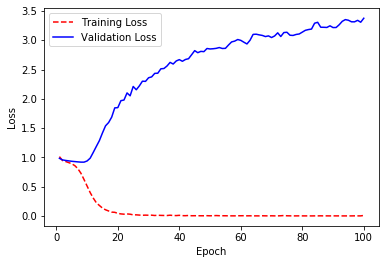

In [60]:
training_loss=history.history['loss']
validation_loss=history.history['val_loss']
epoch_count=range(1,len(training_loss)+1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [61]:
scores = model.evaluate(X_test, y_test, verbose=0)
print(scores)

[3.3772334736513803, 0.5251004016064257]


In [62]:
predictions_test = model.predict(X_test)
print(predictions_test)

[[1.5056416e-03 1.8852703e-04 9.9830580e-01]
 [9.9599481e-01 1.1969421e-06 4.0039564e-03]
 [4.0407460e-05 5.4272283e-03 9.9453235e-01]
 ...
 [9.9472505e-01 5.2672736e-03 7.7443210e-06]
 [5.0813270e-01 4.9109867e-01 7.6870568e-04]
 [3.5285327e-01 2.0202920e-04 6.4694464e-01]]


In [0]:
predictions_test1 = np.zeros_like(predictions_test)
predictions_test1[np.arange(len(predictions_test)), predictions_test.argmax(1)] = 1

In [64]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions_test1))

              precision    recall  f1-score   support

           0       0.73      0.62      0.67      2245
           1       0.32      0.29      0.31       829
           2       0.35      0.51      0.42       910

   micro avg       0.53      0.53      0.53      3984
   macro avg       0.47      0.47      0.46      3984
weighted avg       0.56      0.53      0.53      3984
 samples avg       0.53      0.53      0.53      3984



In [0]:
predicting_df = pd.read_csv("/content/drive/My Drive/Minor Project/hin_test.csv")
vocab_size = 4000000
# encode full sentence into vector
encoded_docs=[one_hot(d,vocab_size) for d in predicting_df['Text']]
max_length = 100
test_df = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
predictions_test = model.predict(test_df)
predictions_test1 = np.zeros_like(predictions_test)
predictions_test1[np.arange(len(predictions_test)), predictions_test.argmax(1)] = 1
predictions_test1 = predictions_test1.argmax(1)
predictions_test1 = pd.Series(predictions_test1)
predictions_test1 = predictions_test1.rename("Label")
ps = predicting_df['ID']
output_df = pd.merge(ps,predictions_test1,how='outer',left_index=True,right_index=True)
output_df['Label'] = output_df['Label'].map({'NAG': 0, 'CAG': 1, 'OAG' : 2})
output_df.head()

In [ ]:
output_df.to_csv("Hindi_TaskA_Run1_CNN_Onehot.csv")